# Predicting Medical Appointment No Shows

In this notebook we will pretend that a major medical panel in Brazil wants us to find out if it is possible to predict whether or not a patient will show up to their scheduled appointment. This [dataset](https://www.kaggle.com/joniarroba/noshowappointments) was found on Kaggle. The data contains ~110,000 scheduled appointments for ~62,000 unique patients. The variables given are patient id number, age, gender, the date and time that appoinment was scheduled as well as the date (but not the time) of the appointment, the neighborhood the hospital is located, scholarship or wellfare assistance, whether or not a text message was received, and several medical conditions or physical ailments.

We will start by gleaming initial information from the dataframe, and do a little bit of cleaning. We will then dive into exploratory analysis and feature engineering, and finally model training and predicting the probability of a no-show for each appointment.

## Importing, Reading, and Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

sns.set_style('darkgrid')
%matplotlib inline

In [2]:
app = pd.read_csv('.../Appointment No Shows.csv')
app.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [3]:
app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


Scheduled Day and Appointment Day are object datatypes instead of datetime. We will change this in order to analyze the different components of time and date. We will also replace our target data into binary values of 0 and 1, 1 representing a no-show. I will create a column called 'Count' filled with 1's to enable easy analysis.

In [4]:
#ScheduledDay and AppointmentDay to time series
app['ScheduledDay'] = app['ScheduledDay'].apply(lambda x: x.replace('T', ' ')[:-1])
app['AppointmentDay'] = app['AppointmentDay'].apply(lambda x: x.replace('T', ' ')[:-1])

app['ScheduledDay'] = pd.to_datetime(app['ScheduledDay'])
app['AppointmentDay'] = pd.to_datetime(app['AppointmentDay'])

#No-show to binary numbers
app['No-show'] = app['No-show'].replace({'No':0, 'Yes':1})
#Column of 1's
app['Count'] = 1

## Analysis and Feature Engineering

In [5]:
app.describe(include='all')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Count
count,1.105270e+05,1.105270e+05,110527,110527,110527,110527.000000,110527,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.0
unique,NaN,NaN,2,103549,27,NaN,81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,F,2016-05-06 07:09:54,2016-06-06 00:00:00,NaN,JARDIM CAMBURI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,71840,24,4692,NaN,7717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,2015-11-10 07:13:56,2016-04-29 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2016-06-08 20:07:23,2016-06-08 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.474963e+14,5.675305e+06,NaN,NaN,NaN,37.088874,NaN,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026,0.201933,1.0
std,2.560949e+14,7.129575e+04,NaN,NaN,NaN,23.110205,NaN,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873,0.401444,0.0
min,3.921784e+04,5.030230e+06,NaN,NaN,NaN,-1.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,4.172614e+12,5.640286e+06,NaN,NaN,NaN,18.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0


The medical condition features are all binary except Handicap which ranges from 0 to 4.

### Recurring Patients

Many of the patients have multiple appointments. Surely they will have patterns of missed appointments.

In [6]:
app.groupby('PatientId').sum().sort_values('Count', ascending=False)['Count'].head(10)

PatientId
8.221459e+14    88
9.963767e+10    84
2.688613e+13    70
3.353478e+13    65
8.713749e+14    62
6.264199e+12    62
2.584244e+11    62
7.579746e+13    62
6.684488e+13    57
8.722785e+11    55
Name: Count, dtype: int64

Can't imagine why someone would have to go to the doctor 88 times in a 2 month stretch, but I'm not sure I want to know. We will label each patient with the fraction that they didn't show up if they had at least 3 appointments. Otherwise, they will be labeled with the leftover average.

In [7]:
appPatient = app.groupby('PatientId').sum()[['No-show', 'Count']]
appPatient['% No-show'] = appPatient['No-show'] / appPatient['Count']
appPatient = appPatient.sort_values('% No-show', ascending=False)
appPatient['PatientId'] = appPatient.index
appPatient['% No-show'].describe()

count    62299.000000
mean         0.196430
std          0.351419
min          0.000000
25%          0.000000
50%          0.000000
75%          0.333333
max          1.000000
Name: % No-show, dtype: float64

In [8]:
app['Patient Occurences'] = np.nan
occurences_dict = dict(zip(appPatient['PatientId'], appPatient['Count']))
app['Patient Occurences'] = app['PatientId'].replace(occurences_dict)

app['% Patient'] = app[app['Patient Occurences'] < 3]['No-show'].mean()
patient_dict = dict(zip(appPatient[appPatient['Count'] >= 3]['PatientId'], appPatient[appPatient['Count'] >= 3]['% No-show']))
app.loc[app['Patient Occurences'] >= 3, '% Patient'] = app.loc[app['Patient Occurences'] >= 3, 'PatientId'].replace(patient_dict)

### Gender and Age

More women seek healthcare than men. Later, we will change the gender column to binary, but we know that 65% of appointments are scheduled for females.

In [9]:
app['Gender'].value_counts()

F    71840
M    38687
Name: Gender, dtype: int64

In [10]:
pd.crosstab(app['Gender'], app['No-show'])

No-show,0,1
Gender,,
F,57246,14594
M,30962,7725


In [11]:
14594 / (14594 + 57246) #% No-show for females

0.20314587973273943

In [12]:
7725 / (7725 + 30962) #% No-show for males

0.19967947889471915

There is no difference in missed appointments purely by gender.

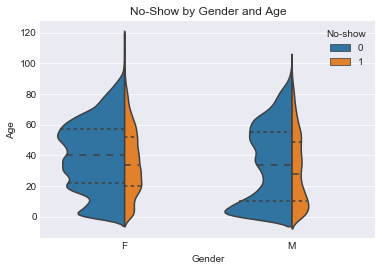

In [13]:
plt.title('No-Show by Gender and Age')
sns.violinplot(x='Gender', y='Age', hue='No-show', data=app, split=True, inner='quart', scale='count')

There is a slight dip for females missing appointments in teenage years.
Now we will group all of the individual ages together and plot the percent that missed appointments for males and females.

In [14]:
appAge = app.pivot_table(values='No-show', index='Age', columns='Gender', aggfunc='mean')
appAge['Age'] = appAge.index

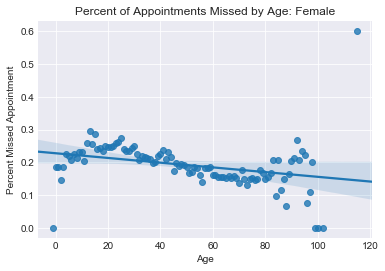

In [15]:
sns.regplot(x='Age', y='F', data=appAge)
plt.ylabel('Percent Missed Appointment')
plt.title('Percent of Appointments Missed by Age: Female')
plt.show()

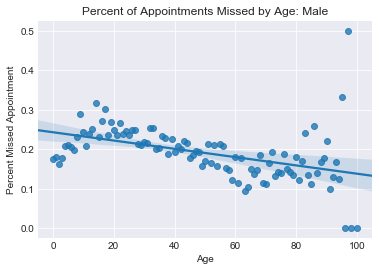

In [16]:
sns.regplot(x='Age', y='M', data=appAge)
plt.ylabel('Percent Missed Appointment')
plt.title('Percent of Appointments Missed by Age: Male')
plt.show()

There is a little more deviation in the y-axis of the male graph. There are three interesting intervals that occur in both maps. The first is a rise in missed appointments until about age 20. The second is a slow decline in missed appointments from 20 to 80. The third is a rise in deviation after age 80. Our outliers occur when there are only a few people of a given age. We will take a look at the first interval seperate and then the second and third intervals together.

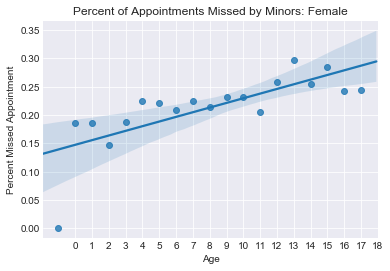

In [17]:
sns.regplot(x='Age', y='F', data=appAge[appAge['Age'] < 18])
plt.ylabel('Percent Missed Appointment')
plt.title('Percent of Appointments Missed by Minors: Female')
plt.xticks(range(19))
plt.show()

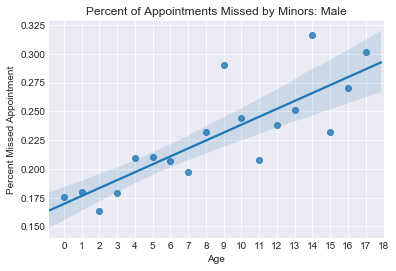

In [18]:
sns.regplot(x='Age', y='M', data=appAge[appAge['Age'] < 18])
plt.ylabel('Percent Missed Appointment')
plt.title('Percent of Appointments Missed by Minors: Male')
plt.xticks(range(19))
plt.show()

These graphs are similar with the exception of a single outlier in the female graph where we have a negative age, which slightly skews the regression line.

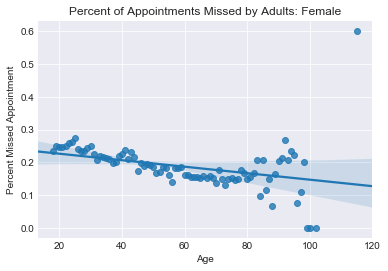

In [19]:
sns.regplot(x='Age', y='F', data=appAge[appAge['Age'] >= 18])
plt.ylabel('Percent Missed Appointment')
plt.title('Percent of Appointments Missed by Adults: Female')
plt.show()

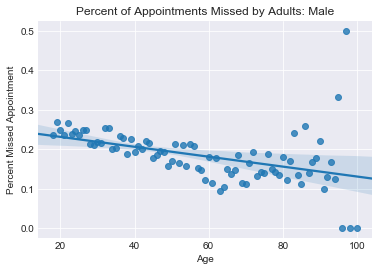

In [20]:
sns.regplot(x='Age', y='M', data=appAge[appAge['Age'] >= 18])
plt.ylabel('Percent Missed Appointment')
plt.title('Percent of Appointments Missed by Adults: Male')
plt.show()

### Neighborhood

There are 81 different neighborhoods. I am sure that each neighborhood has its own pattern of no-shows.

In [21]:
len(app['Neighbourhood'].value_counts())

81

In [22]:
appNeigh = app.groupby('Neighbourhood').sum()[['No-show', 'Count']]
appNeigh['% No-show'] = appNeigh['No-show'] / appNeigh['Count']
appNeigh = appNeigh.sort_values('% No-show', ascending=False)
appNeigh['Neighbourhood'] = appNeigh.index

In [23]:
appNeigh.head(20)

,No-show,Count,% No-show,Neighbourhood
Neighbourhood,,,,
ILHAS OCEÂNICAS DE TRINDADE,2,2,1.000000,ILHAS OCEÂNICAS DE TRINDADE
SANTOS DUMONT,369,1276,0.289185,SANTOS DUMONT
SANTA CECÍLIA,123,448,0.274554,SANTA CECÍLIA
SANTA CLARA,134,506,0.264822,SANTA CLARA
ITARARÉ,923,3514,0.262664,ITARARÉ
JESUS DE NAZARETH,696,2853,0.243954,JESUS DE NAZARETH
HORTO,42,175,0.240000,HORTO
ILHA DO PRÍNCIPE,532,2266,0.234775,ILHA DO PRÍNCIPE
CARATOÍRA,591,2565,0.230409,CARATOÍRA


In [24]:
appNeigh.tail(20)

,No-show,Count,% No-show,Neighbourhood
Neighbourhood,,,,
JABOUR,451,2509,0.179753,JABOUR
NOVA PALESTINA,402,2264,0.177562,NOVA PALESTINA
REDENÇÃO,275,1553,0.177077,REDENÇÃO
SANTO ANTÔNIO,484,2746,0.176256,SANTO ANTÔNIO
PONTAL DE CAMBURI,12,69,0.173913,PONTAL DE CAMBURI
CONSOLAÇÃO,237,1376,0.172238,CONSOLAÇÃO
REPÚBLICA,143,835,0.171257,REPÚBLICA
MATA DA PRAIA,110,644,0.170807,MATA DA PRAIA
MORADA DE CAMBURI,16,96,0.166667,MORADA DE CAMBURI


Almost every neighborhood is between 14.5% and 29.0%. Those that aren't have a small sample population. These values will replace the categorical value of neighborhood for the analysis. For samples with less than 20, we'll replace it with the leftover average.

In [25]:
appNeigh[appNeigh['Count'] <= 20]

,No-show,Count,% No-show,Neighbourhood
Neighbourhood,,,,
ILHAS OCEÂNICAS DE TRINDADE,2,2,1.000,ILHAS OCEÂNICAS DE TRINDADE
ILHA DO FRADE,2,10,0.200,ILHA DO FRADE
AEROPORTO,1,8,0.125,AEROPORTO
PARQUE INDUSTRIAL,0,1,0.000,PARQUE INDUSTRIAL


In [26]:
appNeigh.loc[appNeigh['Count'] <= 20, '% No-show'] = appNeigh['% No-show'].mean()

In [27]:
#Replacing values for neighborhood
percent_dict = dict(zip(appNeigh['Neighbourhood'], appNeigh['% No-show']))
app['% Neighbourhood'] = app['Neighbourhood'].replace(percent_dict)

### Medical Conditions

Instead of having four different columns for seperate medical conditions, it might be appropriate to create a new column that is the sum of the four original columns.

In [28]:
app['Condition Sum'] = app['Hipertension'] + app['Diabetes'] + app['Alcoholism'] + app['Handcap']
app.groupby('Condition Sum').mean()['No-show']

Condition Sum
0    0.209273
1    0.179472
2    0.176913
3    0.169872
4    0.190476
5    1.000000
Name: No-show, dtype: float64

The difference of these values are not significant. There is only one patient who's value of 5. This new column is not worth keeping.

In [29]:
del app['Condition Sum']

### Scheduled in Advance

Now we will create a new column for days scheduled in advance based on datetime information we gained from two original values in our dataframe.

In [30]:
app['Scheduled Ahead'] = (app['AppointmentDay'].apply(lambda x: x.date())
                        - app['ScheduledDay'].apply(lambda x: x.date())).dt.days
app['Scheduled Ahead'].describe(percentiles=[.25, .50, .75, .90, .95, .98])

count    110527.000000
mean         10.183702
std          15.254996
min          -6.000000
25%           0.000000
50%           4.000000
75%          15.000000
90%          30.000000
95%          39.000000
98%          59.000000
max         179.000000
Name: Scheduled Ahead, dtype: float64

95% of the patients scheduled their appointment less than 40 days in advance and 98% of the patients scheduled their appointment less than 60 days in advance. Therefore, we will focus on data below the 98 percentile. Some of this data has a negative value, I will address this later.

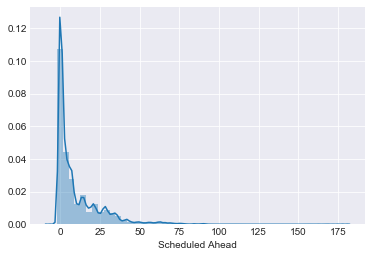

In [31]:
sns.distplot(app['Scheduled Ahead'])

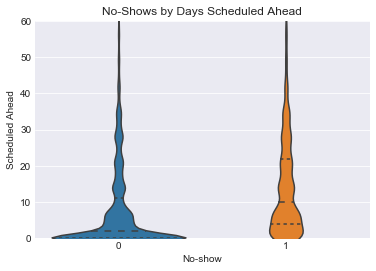

In [32]:
plt.title('No-Shows by Days Scheduled Ahead')
plt.ylim(0, 60)
sns.violinplot(x='No-show', y='Scheduled Ahead', data=app[app['Scheduled Ahead'] <= 60], inner='quart', scale='count')

There is a wide base on the left hand plot because there are a lot of values where days scheduled ahead is zero. I'm not sure if this means the patient just showed up, if they called in and arrived the same day, or something else, but there are over 38,000 instances when scheduled ahead is zero, and over 95% arrived. This is so significant that it might be worth doing this project again cutting out all samples that the appointment is not scheduled ahead. 

Also, as shown below, I have no idea what negative values for this mean, but there are only 5 values like this out of the ~110,000 sample, so I will change them all to zero. The next violin plot will have only positive values for 'Scheduled Ahead'.

In [33]:
app[app['Scheduled Ahead'] <= 3].groupby('Scheduled Ahead')['No-show'].mean()

Scheduled Ahead
-6    1.000000
-1    1.000000
 0    0.046469
 1    0.213505
 2    0.238216
 3    0.235294
Name: No-show, dtype: float64

In [34]:
app[app['Scheduled Ahead'] <= 3]['Scheduled Ahead'].value_counts()

 0    38563
 2     6725
 1     5213
 3     2737
-1        4
-6        1
Name: Scheduled Ahead, dtype: int64

In [35]:
app.loc[app['Scheduled Ahead'] < 0, 'Scheduled Ahead'] = 0

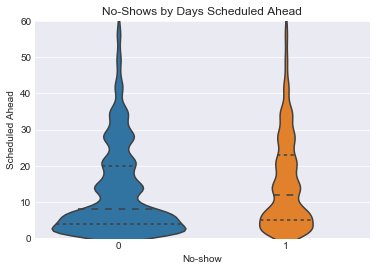

In [36]:
plt.title('No-Shows by Days Scheduled Ahead')
plt.ylim(0, 60)
sns.violinplot(x='No-show', y='Scheduled Ahead', data=app[(app['Scheduled Ahead'] <= 60) & (app['Scheduled Ahead'] > 0)], inner='quart', scale='count')

The highest chance of making an appointment occurs when the appointment is scheduled around a week in advance. Now, like we did with ages, we will group all of the individual days scheduled ahead together and plot the percent that missed appointments.

In [37]:
appSched = pd.DataFrame(app.groupby('Scheduled Ahead').mean()['No-show'])
appSched['Scheduled Ahead'] = appSched.index
app[app['Scheduled Ahead'] < 1]['Scheduled Ahead'].value_counts()
appSched.head()

,No-show,Scheduled Ahead
Scheduled Ahead,,
0,0.046593,0
1,0.213505,1
2,0.238216,2
3,0.235294,3
4,0.232703,4


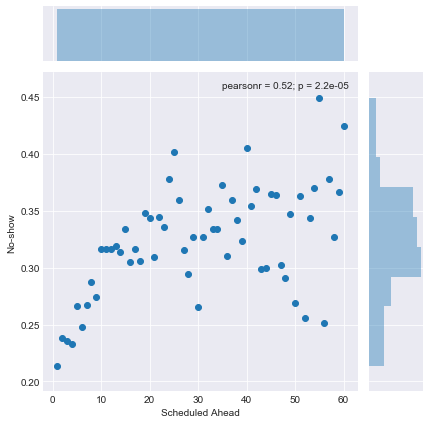

In [38]:
#Veiwing relationship to scheduled ahead and no-show percentage
sns.jointplot('Scheduled Ahead', y='No-show', data=appSched[(appSched['Scheduled Ahead'] >= 1) & (appSched['Scheduled Ahead'] <= 60)])

Our plot can be split in two sections. The first appears linear up until 15-20 days ahead of time. Then it becomes non-linear and highly varied. We will take a look at these two sections seperately. I will use 20 as the border, but you could argue that the start of the variation is at 15.

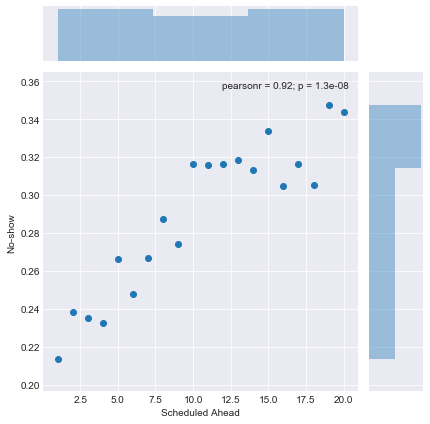

In [39]:
sns.jointplot('Scheduled Ahead', y='No-show', data=appSched[(appSched['Scheduled Ahead'] >= 1) & (appSched['Scheduled Ahead'] <= 20)])

High correlation and low p-value are great signs here. We can conclude that missed appointments are partially a function of days scheduled in advance as long is the this value is <= 20.

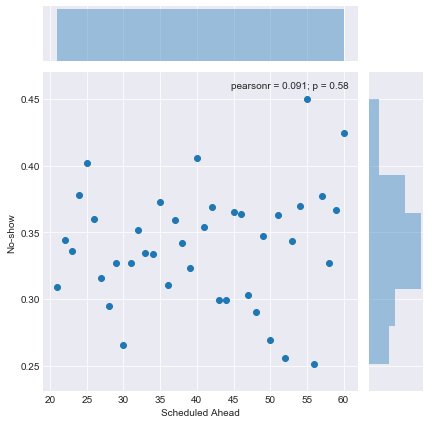

In [40]:
sns.jointplot('Scheduled Ahead', y='No-show', data=appSched[(appSched['Scheduled Ahead'] > 20) & (appSched['Scheduled Ahead'] <= 60)])

We cannot begin to predict whether an appointment will be missed based on days scheduled ahead > 20. Because of this, we will use an average value for all values greater than 20. Now we will look outside of our 98% sample, where values are > 60.

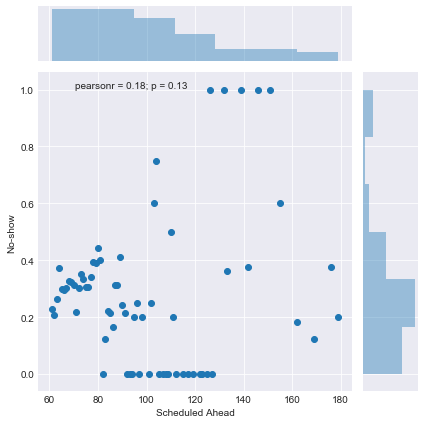

In [41]:
sns.jointplot('Scheduled Ahead', y='No-show', data=appSched[appSched['Scheduled Ahead'] > 60])

This is less than 2% of the entire dataset, and clearly we can't use this information to make a prediction. We will use the same average as those between 20 and 60. It is important we get this information from the original dataframe since the appSched has unbalanced numbers.

In [42]:
mean_20_to_60 = app[(app['Scheduled Ahead'] > 20) & (app['Scheduled Ahead'] <= 60)]['No-show'].mean()
appSched.loc[(appSched['Scheduled Ahead'] > 20) & (appSched['Scheduled Ahead'] <= 60), 'No-show'] = mean_20_to_60

mean_over_60 = app[app['Scheduled Ahead'] > 60]['No-show'].mean()
appSched.loc[appSched['Scheduled Ahead'] > 60, 'No-show'] = mean_over_60

sa_dict = dict(zip(appSched['Scheduled Ahead'], appSched['No-show']))

#Inputting averages into original dataframe
app['% Scheduled Ahead'] = app['Scheduled Ahead'].replace(sa_dict)

### Scheduled Time

Now we will examine whether the time of day the patient called to schedule matters.

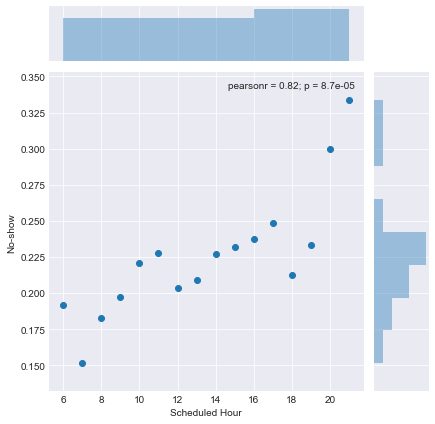

In [43]:
app['Scheduled Hour'] = app['ScheduledDay'].dt.hour
appHour = pd.DataFrame(app.groupby('Scheduled Hour').mean()['No-show'])
appHour['Scheduled Hour'] = appHour.index
sns.jointplot(x='Scheduled Hour', y='No-show', data=appHour)

In [44]:
app['Scheduled Hour'].value_counts()

7     19213
8     15349
9     12823
10    11056
14     9127
13     9036
11     8462
15     8079
16     5542
12     5422
17     2909
6      1578
18     1340
19      488
20      100
21        3
Name: Scheduled Hour, dtype: int64

The earlier in the day the appointment was scheduled, the higher the chance to patient will show up.

In [45]:
sh_dict = dict(zip(appHour['Scheduled Hour'], appHour['No-show']))
app['% Scheduled Hour'] = app['Scheduled Hour'].replace(sh_dict)

### Scheduled Day of the Week

Now that we've looked at the time the patient called to schedule, we will look at the day.

In [46]:
app['Scheduled Day of Week'] = app['ScheduledDay'].dt.dayofweek
schDayOfWeek = pd.DataFrame(app.groupby('Scheduled Day of Week').mean()['No-show'])
schDayOfWeek['Scheduled Day of Week'] = schDayOfWeek.index
app['ScheduledDay'].dt.dayofweek.value_counts()

1    26168
2    24262
0    23085
4    18915
3    18073
5       24
Name: ScheduledDay, dtype: int64

In [47]:
sch_dict = dict(zip(schDayOfWeek['Scheduled Day of Week'], schDayOfWeek['No-show']))
app['% Scheduled Day Of Week'] = app['Scheduled Day of Week'].replace(sch_dict)
schDayOfWeek

,No-show,Scheduled Day of Week
Scheduled Day of Week,,
0,0.197574,0
1,0.202194,1
2,0.201096,2
3,0.204725,3
4,0.205498,4
5,0.041667,5


They are nearly all the same percentage of no-shows except Saturday where there only 24 samples.

In [48]:
del app['% Scheduled Day Of Week']

### Appointment Day of the Week

This is the day of the week of the actual appointment.

In [49]:
app['Appointment Day of Week'] = app['AppointmentDay'].dt.dayofweek
app.groupby('Appointment Day of Week').mean()['No-show']

Appointment Day of Week
0    0.206471
1    0.200936
2    0.196892
3    0.193541
4    0.212261
5    0.230769
Name: No-show, dtype: float64

There is no significant difference here, we will drop the column.

In [50]:
del app['Appointment Day of Week']

### Appointment Month

It would be nice to know if certain months or periods of time result in more missed appointments than others, but in the following command we can tell that all of this data was taken from a short period of time in 2016 that included all of May and parts of April and June.

In [51]:
app['Appointment Month'] = app['AppointmentDay'].dt.month
app['Appointment Month'].value_counts()

5    80841
6    26451
4     3235
Name: Appointment Month, dtype: int64

In [52]:
del app['Appointment Month']

## Modeling

In [53]:
app['Gender'] = app['Gender'].replace({'F': 0, 'M': 1})

In [54]:
app.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show', 'Count',
       'Patient Occurences', '% Patient', '% Neighbourhood', 'Scheduled Ahead',
       '% Scheduled Ahead', 'Scheduled Hour', '% Scheduled Hour',
       'Scheduled Day of Week'],
      dtype='object')

In [55]:
X = app[['Gender', 'Age', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', \
         'Handcap', 'SMS_received', '% Patient', '% Neighbourhood', '% Scheduled Ahead', '% Scheduled Hour']]
y = app['No-show']

clf = RandomForestClassifier()

params = {'n_estimators':[i for i in range(10, 30)],
              'min_samples_leaf':[i for i in range(20, 40)],        
              'min_samples_split':[2 *i for i in range(5,20)],
              'criterion':['gini', 'entropy']}
randSearch = RandomizedSearchCV(clf, param_distributions=params, n_iter=200, cv=10)
randSearch.fit(X, y)
'Accuracy: {}'.format(randSearch.best_score_)

'Accuracy: 0.8221611009074705'

In [56]:
'Best Parameters: {}'.format(randSearch.best_params_)

"Best Parameters: {'n_estimators': 27, 'min_samples_split': 34, 'min_samples_leaf': 37, 'criterion': 'gini'}"

Accuracy of 0.822 is only a slight improvement over our benchmark of 0.798:

In [57]:
len(app[app['No-show'] == 0]) / len(app)

0.798067440534892

We are not getting a great result by predicting which patients won't arrive. So we will calculate the probability a patient will miss their appointment and give that data to the panel.

### Feature Importance

In [58]:
clf = RandomForestClassifier(n_estimators=27, min_samples_split=34, min_samples_leaf=37, criterion='gini')
clf.fit(X, y)
clf.feature_importances_

array([  5.41415540e-03,   5.97897006e-02,   3.11193598e-03,
         3.93639876e-03,   1.05452753e-03,   1.26779780e-03,
         2.51125314e-04,   3.90033268e-02,   5.18167739e-01,
         4.00644437e-02,   3.00251014e-01,   2.76878351e-02])

In [59]:
feature_importances = pd.DataFrame(pd.Series(dict(zip(['Gender', 'Age', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', \
         'Handcap', 'SMS_received', '% Patient', '% Neighbourhood', '% Scheduled Ahead', '% Scheduled Hour'], \
         list(clf.feature_importances_)))), columns=['Importance'])
feature_importances

,Importance
% Neighbourhood,0.040064
% Patient,0.518168
% Scheduled Ahead,0.300251
% Scheduled Hour,0.027688
Age,0.059790
Alcoholism,0.001268
Diabetes,0.001055
Gender,0.005414
Handcap,0.000251
Hipertension,0.003936


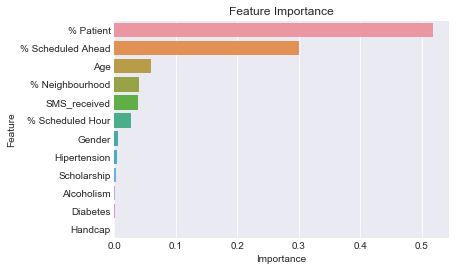

In [60]:
feature_importances['Feature'] = feature_importances.index
feature_importances = feature_importances.sort_values('Importance', ascending=False)
plt.title('Feature Importance')
sns.barplot(x='Importance', y='Feature', data=feature_importances)

Patient history is massively important. So is days scheduled ahead. Age, neighborhood, the time of day of scheduling (not the appointment), SMS-received are moderately important. None of the medical conditions are important.

### Calculating Probabilities

In [61]:
probability_array = clf.predict_proba(X)[:,1]
app['Probability of No-show'] = probability_array
app[['PatientId', 'AppointmentID', 'AppointmentDay', 'No-show', 'Probability of No-show']].head(20)

,PatientId,AppointmentID,AppointmentDay,No-show,Probability of No-show
0,2.987250e+13,5642903,2016-04-29,0,0.010867
1,5.589978e+14,5642503,2016-04-29,0,0.034231
2,4.262962e+12,5642549,2016-04-29,0,0.017212
3,8.679512e+11,5642828,2016-04-29,0,0.044941
4,8.841186e+12,5642494,2016-04-29,0,0.031329
5,9.598513e+13,5626772,2016-04-29,0,0.148119
6,7.336882e+14,5630279,2016-04-29,1,0.334614
7,3.449833e+12,5630575,2016-04-29,1,0.263136
8,5.639473e+13,5638447,2016-04-29,0,0.025206
9,7.812456e+13,5629123,2016-04-29,0,0.272944


Now we will check the distribution of probabilities for made and missed appointments.

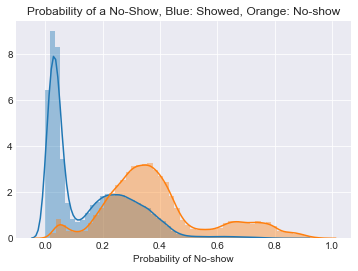

In [62]:
#Not scaled correctly
plt.title('Probability of a No-Show, Blue: Showed, Orange: No-show')
sns.distplot(app[app['No-show'] != 1]['Probability of No-show'])
sns.distplot(app[app['No-show'] == 1]['Probability of No-show'])

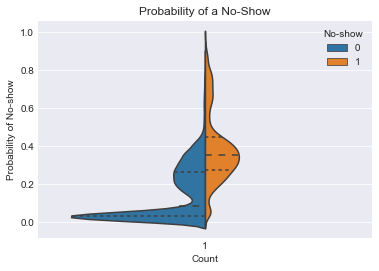

In [63]:
#Scaled Correctly
plt.title('Probability of a No-Show')
sns.violinplot(x='Count', y='Probability of No-show', hue='No-show', data=app, split=True, inner='quart', scale='count')

Our classifier is very accurate predicting patients with less than a 10% probability. The distribution is small from 10%-18%. Then we can see that the classifier has a tough job predicting no-shows for probability from %20-%35. Then from ~40% on the chances become likely that the appointment will be missed.

In [64]:
app[app['No-show'] == 0].describe(percentiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95])['Probability of No-show']

count    88208.000000
mean         0.154865
std          0.144649
min          0.000000
5%           0.009508
10%          0.015589
25%          0.033259
50%          0.085572
75%          0.263847
90%          0.356967
95%          0.405399
max          0.874665
Name: Probability of No-show, dtype: float64

In [65]:
app[app['No-show'] == 1].describe(percentiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95])['Probability of No-show']

count    22319.000000
mean         0.389133
std          0.183738
min          0.017582
5%           0.139190
10%          0.198977
25%          0.273291
50%          0.354876
75%          0.449175
90%          0.694735
95%          0.769570
max          0.956867
Name: Probability of No-show, dtype: float64

## Conclusion

It is difficult to predict specific appointments that will be missed. But, we found risk factors that result in a higher chance of a no-show. These include:

-Reccuring patients: The patient's record of appointment no-shows plays a huge role.

-Age: Chances of missing an appointment rise from age 0 to 20, then slowly decline from 20 to 80.

-Neighborhood: (or location of the appointment)

-Days scheduled ahead: Patients are less likely to miss their appointment when they scheduled it shortly ahead of time. The probability they miss the appointment increases with days scheduled ahead, until that is about 20, then it doesn't matter.

-Hour scheduled: The hour the patient scheduled the appointment (not the appointment time) affected the probability slightly. The earlier the patient scheduled it the more likely he/she made the appointment.

-Receiving a text message alert had a slight impact.

Things that matter less:

-The gender of the patient

-The day of the week of the appointment and the day of the week the appointment was scheduled ahead

-Medical conditions

All this being considered, we can give the panel our assessment and they can use the model on unseen, future data. The medical personnel can use the information, mainly the probability that was calculated and risk factors involved to try to improve medical appointment attendence. More data can return to us and we can see what has changed.